In [1]:
import pandas as pd
import nltk
import string
import re
import h2o
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
tmp_df = pd.read_csv('D:/marco/vr_chat-master/Marco/train_yn.csv')
tmp_df = tmp_df.replace(['yes', 'no'], ['Yes', 'No'])
tmp_df.head()

,passages,query,query_id,query_type,answers_yn
0,"[Row(is_selected=0, passage_text=u'In his youn...",was ronald reagan a democrat,19700,description,Yes
1,"[Row(is_selected=0, passage_text=u'So, in the ...",do game shows pay their contestants,19749,description,Yes
2,"[Row(is_selected=0, passage_text=u'Even though...",does peanut butter contain cholesterol,19761,description,No
3,"[Row(is_selected=0, passage_text=u'When turnin...",can you take left hand lane to turn right on a...,19762,description,No
4,"[Row(is_selected=0, passage_text=u'Assault on ...",is armed assault a felony,19774,description,Yes


In [3]:
def print_dataDis(df=tmp_df):
    print df['answers_yn'].unique()
    print len(df[df['answers_yn'] == 'Yes']), '|', len(df[tmp_df['answers_yn'] == 'No'])
    print 'fraction of No: ', len(df[df['answers_yn'] == 'No'])/ float(len(df[df['answers_yn'] == 'No']) + 
                                                                  float(len(df[df['answers_yn'] == 'Yes'])))

In [4]:
print_dataDis()

['Yes' 'No']
4877 | 1564
fraction of No:  0.242819437975


In [5]:
def plt_bar(df =tmp_df):
    yes=len(df[df['answers_yn'] == 'Yes'])
    no=len(df[df['answers_yn'] == 'No'])
    plt.bar([10,11], [yes, no] )
    plt.xticks([10.5,11.5],['Yes','No'])
    plt.show()

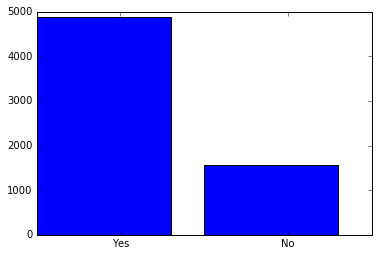

In [6]:
plt_bar()

In [7]:
def over_samp_fra(df=tmp_df, fraction =0.7):
    over_samp = df[df['answers_yn'] == 'No'].sample(frac=fraction, replace=True)
#     print len(over_samp)
    return df.append(over_samp)

In [8]:
over_samp_df= over_samp_fra()
print_dataDis(over_samp_df)

['Yes' 'No']
4877 |

D:\DATO\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


 2659
fraction of No:  0.35283970276


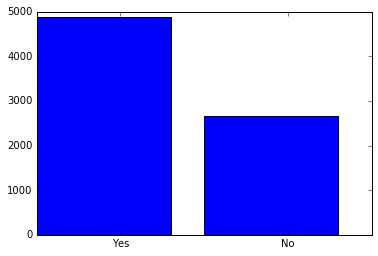

In [9]:
plt_bar(over_samp_df)

In [10]:
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer

from nltk.stem.porter import *

# tf-idf 

In [44]:
def tf_cln(sent = tmp_df.iloc[0][0],cln=True):

    lowers= sent.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    slt_sent = re.findall(r'passagetext(.*?)url',no_punctuation)
    
    if(cln==True):
        slt_sent = re.findall(r'passage_text(.*?)url',sent)
    else:
        slt_sent = sent
        
    token = nltk.word_tokenize(str(slt_sent))
    filtered_sentence = [w for w in token if not w in stop_words]

    for i in filtered_sentence:
        if re.findall(r'^\W.*',str(i)):
            stop_words.add(i)
    stop_words.add('``')
    filtered_sentence = [w for w in token if not w in stop_words]

    tf = nltk.FreqDist(filtered_sentence)
    
    return dict(tf)

In [45]:
def get_tf_idf(dic):
    transformer = TfidfTransformer(smooth_idf=False)
    tf_idf=transformer.fit_transform(dic.values())
    return tf_idf.toarray()

In [46]:
def convt_lst(arr):
    return (pd.DataFrame(arr).iloc[0,:])

In [50]:
#########save over_samp_df to tmp_df to upcoming var assign#########
tmp_df = over_samp_df

In [52]:
lst_tfidf_psg=[]
for i in tmp_df.iloc[:,0]:
    lst_tfidf_psg.append(list(convt_lst(get_tf_idf(tf_cln(i)))))

In [53]:
lst_tfidf_qry = []
for i in tmp_df.iloc[:,1]:
    lst_tfidf_qry.append(list(convt_lst(get_tf_idf(tf_cln(i,False)))))

In [54]:
tmp_df = tmp_df.replace(tmp_df['query_type'].unique(),range(0,len(tmp_df['query_type'].unique())))
tmp_df['passages'] = lst_tfidf_psg
tmp_df['query'] = lst_tfidf_qry
tmp_df = tmp_df.replace(['yes', 'no'], ['Yes', 'No'])
tmp_df = tmp_df.replace(['Yes', 'No'], ['1', '0'])

In [56]:
tmp_df.head(10)

,passages,query,query_id,query_type,answers_yn
0,"[0.034523833988, 0.069047667976, 0.03452383398...","[0.57735026919, 0.57735026919, 0.57735026919]",19700,0,1
1,"[0.0283410100633, 0.510138181139, 0.1700460603...","[0.5, 0.5, 0.5, 0.5]",19749,0,1
2,"[0.0436020720197, 0.0872041440394, 0.087204144...","[0.5, 0.5, 0.5, 0.5]",19761,0,0
3,"[0.025515518154, 0.025515518154, 0.06378879538...","[0.333333333333, 0.333333333333, 0.33333333333...",19762,0,0
4,"[0.0286534127531, 0.0286534127531, 0.028653412...","[0.57735026919, 0.57735026919, 0.57735026919]",19774,0,1
5,"[0.0229900244936, 0.0459800489872, 0.022990024...","[0.707106781187, 0.707106781187]",19784,0,1
6,"[0.023131050103, 0.0462621002059, 0.0231310501...","[0.707106781187, 0.707106781187]",19813,0,0
7,"[0.0209151935046, 0.0209151935046, 0.020915193...","[0.5, 0.5, 0.5, 0.5]",19829,0,1
8,"[0.0209151935046, 0.0209151935046, 0.020915193...","[0.5, 0.5, 0.5, 0.5]",19829,0,0
9,"[0.0506369683542, 0.0506369683542, 0.050636968...","[0.5, 0.5, 0.5, 0.5]",19830,0,1


In [58]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,07 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,2 months and 15 days
H2O cluster name:,H2O_from_python_user_mt10a9
H2O cluster total nodes:,1
H2O cluster free memory:,896 Mb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [59]:
hdf_tfidf_psg = h2o.H2OFrame(lst_tfidf_psg)
hdf_tfidf_qry = h2o.H2OFrame(lst_tfidf_qry)

hdf_tfidf = hdf_tfidf_psg.cbind(hdf_tfidf_qry)
hdf_tfidf = hdf_tfidf.cbind(h2o.H2OFrame(tmp_df[tmp_df.columns[2:3]]))


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [60]:
hdf_target = h2o.H2OFrame(pd.DataFrame(tmp_df.answers_yn))
hdf = h2o.H2OFrame.cbind(hdf_tfidf,h2o.H2OFrame.asfactor(hdf_target))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [61]:
hdf.head(1)

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200
0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.103572,0.103572,0.310715,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0690477,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.207143,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.103572,0.0690477,0.172619,0.0345238,0.0345238,0.0345238,0.103572,0.0690477,0.0345238,0.103572,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.103572,0.0345238,0.0690477,0.0345238,0.0690477,0.0690477,0.0345238,0.103572,0.0345238,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.138095,0.0690477,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.103572,0.0690477,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.207143,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.517858,0.0345238,0.103572,0.0345238,0.0345238,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.172619,0.0345238,0.103572,0.0690477,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.103572,0.0690477,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.138095,0.0345238,0.0345238,0.0345238,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [62]:
hdf_train, hdf_validate=hdf.split_frame(ratios=[0.75], seed =5010)

In [64]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [65]:
nb =H2ONaiveBayesEstimator(seed =1)
nb.train(x = hdf.columns[0:len(hdf.col_names)-1], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [66]:
nb.auc()

0.0

In [71]:
gbm_model = H2OGradientBoostingEstimator(seed =1,  ntrees = 500, learn_rate = .05)
gbm_model.train(x = hdf.columns[0:len(hdf.col_names)-1], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


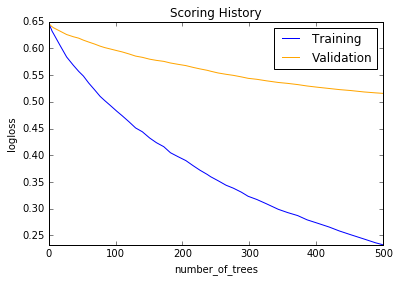

In [72]:
gbm_model.plot()

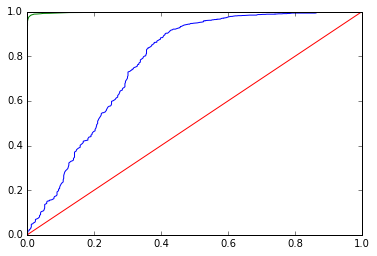

In [73]:
roc_valid = gbm_model.roc(valid=True)
roc_train= gbm_model.roc()

plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))

In [83]:
dl = H2ODeepLearningEstimator(seed =1,epochs =700,hidden=[50,50], model_id='dl1')
dl.train(x = hdf.columns[0:len(hdf.col_names)-1], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


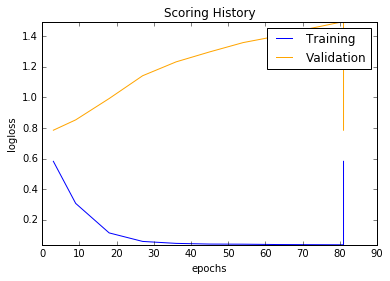

In [85]:
dl.plot()

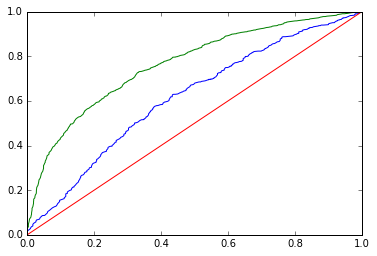

In [86]:
roc_valid = dl.roc(valid=True)
roc_train= dl.roc()

plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))

In [88]:
print "Gradient Boosting Machine Results"
print '=================================================================='
print 'Training AUC:', gbm_model.auc(train=True), '| Validation AUC: ', gbm_model.auc(valid=True)

print "\nDeep Learning Results"
print '=================================================================='
print 'Training AUC:', dl.auc(train=True), '| Validation AUC: ', dl.auc(valid=True)

Gradient Boosting Machine Results
Training AUC: 0.998309651253 | Validation AUC:  0.77203932615

Deep Learning Results
Training AUC: 0.763406841554 | Validation AUC:  0.61442471276


# Bag of Words

In [11]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))


In [12]:
def tf_cln(sent = tmp_df.iloc[0][0],cln=True):

    lowers= sent.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    slt_sent = re.findall(r'passagetext(.*?)url',no_punctuation)
    
    if(cln==True):
        slt_sent = re.findall(r'passage_text(.*?)url',sent)
    else:
        slt_sent = sent
        
    token = nltk.word_tokenize(str(slt_sent))
    filtered_sentence = [w for w in token if not w in stop_words]

    for i in filtered_sentence:
        if re.findall(r'^\W.*',str(i)):
            stop_words.add(i)
        
    stop_words.add('``')
    filtered_sentence = [w for w in token if not w in stop_words]

    tf = nltk.FreqDist(filtered_sentence)
    
    return dict(tf)

In [13]:
#########save over_samp_df to tmp_df to upcoming var assign#########
tmp_df = over_samp_df

In [14]:
lst_tf_psg=[]
for i in tmp_df.iloc[:,0]:
    lst_tf_psg.append(tf_cln(i))

In [15]:
lst_tf_qry = []
for i in tmp_df.iloc[:,1]:
    lst_tf_qry.append(tf_cln(i,False))

In [16]:
tmp_df = tmp_df.replace(tmp_df['query_type'].unique(),range(0,len(tmp_df['query_type'].unique())))
tmp_df['passages'] = lst_tf_psg
tmp_df['query'] = lst_tf_qry
tmp_df = tmp_df.replace(['yes', 'no'], ['Yes', 'No'])
tmp_df = tmp_df.replace(['Yes', 'No'], ['1', '0'])

In [17]:
del(tmp_df['query_id'])

In [18]:
tmp_df.head()

,passages,query,query_type,answers_yn
0,"{u'Wilson': 1, u'United': 2, u'switched': 1, u...","{u'ronald': 1, u'reagan': 1, u'democrat': 1}",0,1
1,"{u'United': 1, u'show': 18, u'money': 6, u'Jeo...","{u'pay': 1, u'game': 1, u'shows': 1, u'contest...",0,1
2,"{u'serving': 1, u'saturated': 2, u'unhealthy':...","{u'butter': 1, u'peanut': 1, u'contain': 1, u'...",0,0
3,"{u'already': 2, u'show': 2, u'When': 5, u'mark...","{u'lane': 1, u'right': 1, u'carriageway': 1, u...",0,0
4,"{u'sentence': 1, u'Deadly': 1, u'rob': 1, u'mi...","{u'felony': 1, u'assault': 1, u'armed': 1}",0,1


In [19]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,22 mins 31 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,2 months and 15 days
H2O cluster name:,H2O_from_python_user_mt10a9
H2O cluster total nodes:,1
H2O cluster free memory:,848 Mb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [20]:
hdf_tf=h2o.H2OFrame(tmp_df[tmp_df.columns[0:3]])
hdf_target = h2o.H2OFrame(pd.DataFrame(tmp_df.answers_yn))
hdf = h2o.H2OFrame.cbind(hdf_tf,h2o.H2OFrame.asfactor(hdf_target))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
hdf.head(1)

passages,query,query_type,answers_yn
"{'Wilson': 1, 'United': 2, 'switched': 1, 'votes\\\\u2014the': 1, 'supported': 1, 'years': 2, 'four': 1, 'radio': 1, '1962': 2, 'Ford': 1, '1948': 1, 'voter': 1, 'candidate': 3, 'former': 3, 'Ronald': 9, 'video.duration.momentjs': 1, 'candidates': 1, 'small-town': 1, '8': 1, 'campaigned': 2, 'views': 1, 'Re-Election': 1, 'early': 2, 'party': 3, 'Illinois': 1, 'presidential': 1, 'defected': 1, 'witched': 1, 'Raised': 1, 'Republican': 6, 'Liberal': 1, 'commentator': 1, '51': 1, '50': 1, 'disillusioned': 1, 'either': 1, 'found': 1, '538': 1, 'working-class': 1, 'From': 1, 'people': 1, 'Gerald': 1, 'Wikipedia': 1, '1960s': 2, 'challenger': 1, 'economic': 1, 'election': 2, 'Listen': 1, 'even': 1, 'ultimately': 1, 'said': 1, 'fundamentally': 1, 'electoral': 1, 'conservative': 2, '525': 1, 'mate': 2, 'During': 1, 'America': 1, 'ever': 1, 'Mondale': 3, 'He': 2, 'U.S.': 5, 'Bill': 1, 'however': 1, 'free': 1, 'Democrat': 3, 'Ferraro': 2, 'Northerner': 1, 'served': 3, 'put': 1, 'path': 1, '1935-': 2, 'Nixon': 1, 'received': 1, 'Jimmy': 1, 'Clinton': 1, 'carried': 1, 'country': 1, 'changed': 2, 'became': 3, '1970s': 1, 'Yes': 2, 'think': 1, 'first': 2, 'major': 2, 'useful': 1, 'political': 3, 'When': 1, 'number': 2, 'officially': 1, 'female': 2, 'parties': 1, 'old': 1, 'Hollywood': 1, '1984': 4, '1980': 2, '1981': 2, 'trajectory': 1, 'support': 1, 'June': 1, '1989': 2, 'California': 3, 'way': 2, 'vice-presidential': 2, 'white': 1, '40th': 2, 'life': 1, 're-elected': 1, '6': 1, 'American': 2, 'dramatic': 1, 'Harry': 1, '1911': 1, 'Democratic': 6, 'November': 3, 'Carter': 1, 'grew': 1, 'politician': 1, 'presidency': 1, 'reelected': 2, 'Reagan': 15, 'elections': 1, 'governor': 3, 'recording': 1, 'time': 1, 'landslide': 3, 'age': 1, '20s': 1, 'Richard': 1, 'voters': 1, 'states': 1, 'ready': 1, 'Party': 5, 'sounding': 1, 'Walter': 3, 'States': 2, 'different': 2, 'traditionally': 1, 'us': 1, '49': 1, 'rather': 1, 'began': 1, '1967': 1, 'actor': 3, 'member': 2, '5': 1, 'largest': 1, 'President': 2, 'A': 1, 'February': 1, 'I': 1, 'Geraldine': 2, 'earlier': 1, 'running': 2, 'president': 1, 'Democrat\\': 1, 'desert': 1, 'younger': 1, 'Truman': 1, 'especially': 1, '1975': 1, 'later': 1, 'defeating': 3, 'deserted': 1, 'encyclopedia': 1, 'Democrats': 1, '2004': 1, 'In': 4, 'Duration': 1, 'audio': 1, '1911-2004': 1}","{'ronald': 1, 'reagan': 1, 'democrat': 1}",0,1


In [22]:
hdf_train, hdf_validate=hdf.split_frame(ratios=[0.75], seed =5010)

In [23]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [24]:
nb =H2ONaiveBayesEstimator(seed =1)
nb.train(x = ['query','query_type','passages'], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [25]:
nb.auc()

0.04080739473947178

In [47]:
gbm_model = H2OGradientBoostingEstimator(seed =1,  ntrees = 2500, learn_rate = .05)
gbm_model.train(x = ['query','query_type','passages'], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


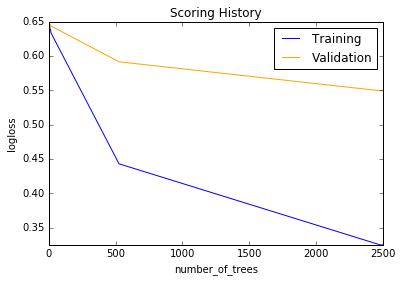

In [48]:
gbm_model.plot()

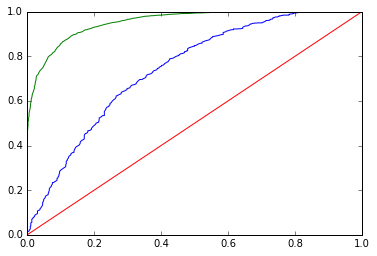

In [49]:
roc_valid = gbm_model.roc(valid=True)
roc_train= gbm_model.roc()

plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))

In [68]:
dl = H2ODeepLearningEstimator(seed =1,epochs =50,hidden=[20,20,20], model_id='dl1')
dl.train(x = ['query','query_type','passages'], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


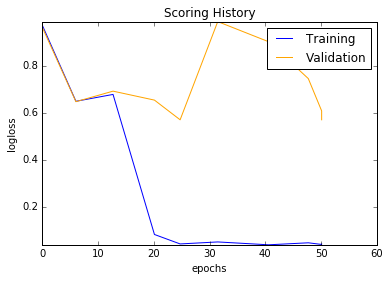

In [69]:
dl.plot()

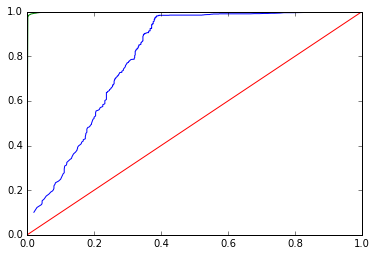

In [70]:
roc_valid = dl.roc(valid=True)
roc_train= dl.roc()

plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))

In [71]:
print "Gradient Boosting Machine Results"
print '=================================================================='
print 'Training AUC:', gbm_model.auc(train=True), '| Validation AUC: ', gbm_model.auc(valid=True)

print "\nDeep Learning Results"
print '=================================================================='
print 'Training AUC:', dl.auc(train=True), '| Validation AUC: ', dl.auc(valid=True)

Gradient Boosting Machine Results
Training AUC: 0.954606465088 | Validation AUC:  0.742288062267

Deep Learning Results
Training AUC: 0.998617715615 | Validation AUC:  0.802913758689
